In [1]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [2]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
path="datasets/ofg_family/"
randomiser = np.random.RandomState(123)

In [4]:
def generate_image(family_dir):
    dic={}
    sub=[a for a in listdir(path+"/"+family_dir)]
    
    for ele in sub:
        mypath = path+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    
    for family in families_batch:
        res = generate_image(family)
        if( res != None):
            np_images.append(res)
    
    return np_images

In [5]:
#full_data = load_npdata(path)
#print(len(full_data))

for r, d, f in os.walk(path):
        all_families=d
        break

randomiser.shuffle(all_families)

train_families = all_families[:-500]
test_families = all_families[-500:]

create encoder decoder supervised pipeling operation
input: stacked images of father and mother (32,32,6)
encoder -> decoder -> image reconstruction
reconstruction loss w/ target image as child

In [6]:
concat = tf.keras.layers.Concatenate()

family_data = generate_image(all_families[0])
inp = concat([family_data[0],family_data[1]])
child = family_data[3]
child = tf.convert_to_tensor(child, dtype=tf.float32)


In [7]:
OUTPUT_CHANNELS = 3

In [8]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=True))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [33]:
def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=True))

    result.add(tf.keras.layers.BatchNormalization())


    result.add(tf.keras.layers.ReLU())

    return result

In [34]:
def upsample_nostride(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())


    result.add(tf.keras.layers.ReLU())

    return result

In [35]:
sd_random_normal_init = 0.135

In [12]:
def EncoderNN():
  down_stack = [
    downsample(32, 8, apply_batchnorm=True), #32x32x32
    downsample(64, 8, apply_batchnorm=False),#16x16x64
    downsample(128, 8, apply_batchnorm=False)#8x8x128
  ]

  up_stack = [
    upsample(128, 8),#16x16x128
    upsample(64, 8),#32x32x64
    upsample(32, 8),  #64x64x32
#     upsample_nostride(16,4),
#     upsample_nostride(8,4)
  ]

  initializer = tf.random_normal_initializer(0., sd_random_normal_init)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[64,64,6])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
    
  x = last(x)


  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
concat = tf.keras.layers.Concatenate()

In [14]:
encoder_optimizer = tf.keras.optimizers.Adam(0.0005)

In [15]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [29]:
def train_encoder(inp_batch, target_batch,b_size):
    with tf.GradientTape() as enc_tape:
        
        inp_batch = tf.unstack(inp_batch)
        target_batch = tf.unstack(target_batch)

        encoder_loss =tf.Variable(0,dtype='float32')

        for idx,input_image in enumerate(inp_batch):
            gen_output = encoder(input_image[tf.newaxis,...], training=True)
            encoder_loss = encoder_loss + tf.reduce_mean(tf.abs(target_batch[idx] - gen_output))
            

        encoder_loss/=b_size
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [30]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            loss_i =np.array([])
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_train = tf.convert_to_tensor(concat([batch_data[:,0],batch_data[:,1]]),dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_train,Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [36]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
EPOCHS = 1
batch = 250
encoder = EncoderNN()

with tf.device('/cpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.75173724
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.7152041
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.66041934
Trained for batch 3/6
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.6185677
Trained for batch 4/6
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.57408905
Trained for batch 5/6
Generated batch (250, 4, 64, 64, 3)
ENCODER_LOSS:  0.5370635
Trained for batch 6/6
______________________________TRAINING COMPLETED_______________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0
1.0


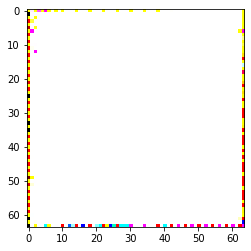

In [32]:
family_data = generate_image(all_families[700])
inp = concat([family_data[0],family_data[1]])
inp = tf.cast(inp, tf.float32)
gen_output = encoder(inp[tf.newaxis,...], training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))
# print(encoder.trainable_weights[0][0][0][0])

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., sd_random_normal_init)

    inp = tf.keras.layers.Input(shape=[64, 64, 6], name='input_image')
    tar = tf.keras.layers.Input(shape=[64, 64, 3], name='target_image')

    x = tf.reshape(tf.keras.layers.concatenate([inp, tar]),(1,64,64,9))
    down1 = downsample(32, 4, True)(x)
    down2 = downsample(64, 4,True)(down1) 
    down3 = downsample(128, 4,True)(down2) 

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=True)(down3)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(leaky_relu) 
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
gen_output = encoder(inp[tf.newaxis,...], training=False)

target = family_data[2]
discriminator = Discriminator()
disc_out = discriminator([inp, tf.squeeze(gen_output)], training=False)
print(disc_out.numpy().shape)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output,dtype=tf.float32), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output,dtype=tf.float32), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output,dtype=tf.float32), disc_generated_output)
  # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def train_step(inp_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        inp_batch = tf.unstack(inp_batch)
        target_batch = tf.unstack(target_batch)

        gen_loss =tf.Variable(0,dtype='float32')
        disc_loss =tf.Variable(0,dtype='float32')

        for idx,input_image in enumerate(inp_batch):
            gen_output = encoder(input_image[tf.newaxis,...], training=True)
            disc_real_output = discriminator([input_image, target_batch[idx]], training=True)
            disc_generated_output = discriminator([input_image, tf.squeeze(gen_output)], training=True)
            gen_loss = gen_loss + generator_loss(disc_generated_output, gen_output, target_batch[idx])
            disc_loss = disc_loss + discriminator_loss(disc_real_output, disc_generated_output)


        gen_loss/=b_size
        disc_loss/=b_size
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))

            print("Generated batch", batch_data.shape)

            X_train = tf.convert_to_tensor(concat([batch_data[:,0],batch_data[:,1]]),dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_train,Y_train,batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
EPOCHS = 1
batch = 300
encoder = EncoderNN()
discriminator = Discriminator()

In [ ]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

In [ ]:
with tf.device('/cpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

In [ ]:
family_data = generate_image(all_families[502])
inp = concat([family_data[0],family_data[1]])
inp = tf.cast(inp, tf.float32)
gen_output = encoder(inp[tf.newaxis,...], training=False)
print(tf.reduce_min(gen_output))
print(tf.reduce_max(gen_output))
plt.imshow(gen_output[0,...])